# Lab Assignment Five: Wide and Deep Network Architectures

By : Katie Rink

### Business Case
Whenever a person goes to apply for someone to trust them to be good for a large sum of money, such as a mortgage or a line of credit. To determine said reliability, the lender utilizes the credit score, which is dependent on a variety of factors. As the customer seeking a loan, it is important for them to understand what factors allow them to maximize their credit score. </br> 

Within the public domain of Kaggle, there is a large database that holds information on the known factors associated with credit score, and the final given credit score. It contains over 100000 datapoints, and it utilizes both numeric and categorical data. </br> 

We hope to dive into an analysis of the factors listed and create some simple visualizations to explain how their credit score is developed, and what trends good credit scores follow. Thus, the main prediction task here is to classify the credit score of a customer based on their credit-related attributes. This is of direct interest to third parties (such as companies) that want to a tool to reduce the efforts to classify their customer's credit scores. Consequently, for the prediction algorithm to be considered useful, it needs to be fairly accurate when applied to our test data in predicting the credit scores of the test customers. </br> 

More specifically, we would like to be able to have around or higher than an 80% accuracy, due to that being the generally considered average value of prediction from sites that perform similar functions. Additionally, we would prefer to focus on minimize false positives, especially with higher credit scores because that would mean we are falsely stating a person has a high credit score, when they do not. Since our goal is to aid consumers in maximizing their credit score, it is better to have customers assume and attempt to put more work into their credit score, rather than feel falsely secure and do nothing to improve their credit score.</br>

Overally, we are looking for what factors most affect credit score, and the general trends credit scores tend to follow.

Data Set : Credit Card Classification - https://www.kaggle.com/datasets/parisrohan/credit-score-classification?select=train.csv

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

#Loading the dfset
df = pd.read_csv('../Data/credit_score/test.csv', low_memory=False)

#Showing df
df.info()
df.head()
print(df.shape)

2022-11-15 20:41:31.271684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

### Pre-Processing

First, I want to remove aal variables that we will not be using, so that we have a set of defined class variables. .

In [2]:
#Select which variables to use
df.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1, inplace=True)

Next, I want to clean the dataset by removing all null values so that our df is easy to work with.

In [3]:
# Get rid of rows with any missing df
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.extract(r'(\d+)')
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].fillna(0)
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].astype(int)

#Replace any invalid values
df['Num_Credit_Inquiries']  = df['Num_Credit_Inquiries'].fillna(0)
df['Amount_invested_monthly']=df['Amount_invested_monthly'].replace('__10000__', 0).astype(float)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].replace('_', '').astype(float)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].fillna(0)
df['Amount_invested_monthly'].isnull().sum()
df['Monthly_Balance'] = df['Monthly_Balance'].fillna(0)
df['Monthly_Balance']=df['Monthly_Balance'].replace('__-333333333333333333333333333__', 0).astype(float)
df['Age'] = df['Age'].str.extract('(\d+)', expand=False).astype(int)

df['Annual_Income'] = df['Annual_Income'].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)

df['Num_of_Loan'] = df['Num_of_Loan'].str.extract('(\d*\.\d+|\d+)', expand=False)
df['Num_of_Loan'] = df['Num_of_Loan'].astype(int)

df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].fillna(0)

df['Outstanding_Debt'] = df['Outstanding_Debt'].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)

#Convert Age to a numeric value
df['Credit_History_Age'] = df['Credit_History_Age'].str[:2]
df['Credit_History_Age'] = df[['Credit_History_Age']].apply(pd.to_numeric)
df['Credit_History_Age'] = df['Credit_History_Age'].fillna(0) 

#Removing all final null values from the dataset
df = df.replace(r'[^\w\s.]|_|-', '', regex=True) 
df.replace('', np.nan, inplace=True)
df.replace(to_replace=' ?',value=np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index()

df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,September,23,Scientist,19114.12,1824.843333,3,4,3,4,3,...,2022.0,Good,809.98,35.030402,22.0,No,49.574949,236.642682,LowspentSmallvaluepayments,186.266702
1,October,24,Scientist,19114.12,1824.843333,3,4,3,4,3,...,4.0,Good,809.98,33.053114,22.0,No,49.574949,21.465380,HighspentMediumvaluepayments,361.444004
2,November,24,Scientist,19114.12,1824.843333,3,4,3,4,-1,...,4.0,Good,809.98,33.811894,0.0,No,49.574949,148.233938,LowspentMediumvaluepayments,264.675446
5,October,28,Teacher,34847.84,3037.986667,2,4,6,1,3,...,5.0,Good,605.03,30.116600,27.0,No,18.816215,251.627369,LowspentLargevaluepayments,303.355083
9,October,35,Engineer,143162.64,12187.220000,1,5,8,3,6,...,3.0,Good,1303.01,35.685836,18.0,No,246.992319,453.615131,LowspentLargevaluepayments,788.114550


Next we begin to preprocess the dataframe by encoding categorical data as integers first <br/>

In [4]:
#Encode categorical df as integers  
encoders = dict() # save each encoder in dictionary
categorical_headers = ['Month', 'Occupation', 'Credit_Mix' ,'Payment_of_Min_Amount', 'Payment_Behaviour']

for col in categorical_headers:
    df[col] = df[col].str.strip()
    df[col] = df[col].str.strip()
    if col == "Credit_Mix":
        # special case the target, just replace the column
        tmp = LabelEncoder()
        df[col] = tmp.fit_transform(df[col])
    else : 
        # integer encode strings that are features
        encoders[col] = LabelEncoder() # save the encoder
        df[col+'_int'] = encoders[col].fit_transform(df[col])
    
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Month_int,Occupation_int,Payment_of_Min_Amount_int,Payment_Behaviour_int
0,September,23,Scientist,19114.12,1824.843333,3,4,3,4,3,...,22.0,No,49.574949,236.642682,LowspentSmallvaluepayments,186.266702,3,12,1,6
1,October,24,Scientist,19114.12,1824.843333,3,4,3,4,3,...,22.0,No,49.574949,21.465380,HighspentMediumvaluepayments,361.444004,2,12,1,2
2,November,24,Scientist,19114.12,1824.843333,3,4,3,4,-1,...,0.0,No,49.574949,148.233938,LowspentMediumvaluepayments,264.675446,1,12,1,5
5,October,28,Teacher,34847.84,3037.986667,2,4,6,1,3,...,27.0,No,18.816215,251.627369,LowspentLargevaluepayments,303.355083,2,13,1,4
9,October,35,Engineer,143162.64,12187.220000,1,5,8,3,6,...,18.0,No,246.992319,453.615131,LowspentLargevaluepayments,788.114550,2,4,1,4


Next, I began to preprocess the data. First I scaled the numberic values in the dataset so that they followed a more normalized spread. This allowed me to more accurately predict the data later. 

In [5]:
# scale the numeric, continuous variables
numeric_headers = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

ss = StandardScaler()
df[numeric_headers] = ss.fit_transform(df[numeric_headers].values)

Then I printed all of the variables I would be using in the category the fell into. Below, I included a description of each of the variables.  <br/>
**Categorical :** <br/>
> Month : *The month from which the data was collected during. Based on what kind of season is, it may be a higher spend season, and therefore this will affect how a person is spending during that time* <br/>
> Occupation : *The occupation the person who has each credit score works. This would generally affect the income of a person, and therefore how much debt they may be in.* <br/>
> Credit_Mix : *The credit score of the person, which is what we will be attempting to predict based on other factors.* <br/>
> Payment_of_Min_Amount : *Whether or not a person has payed the minimum amount due for their credit card during the current month* <br/>
> Payment_Behaviour : *What type of spending the user is utilizing and how much those payments are going towards. This affects how much the user is able to pay off.* <br/>

**Categorical :** <br/>
> Age : *The age of the user, which would affect how much time they have had to accumulate history* <br/>
> Annual_Income : *The amount that an user earns every year, which would affect how much they can be trusted to pay back* <br/>
> Monthly_Inhand_Salary : *The amount an user has to spend each month, which would also affect how much they can pay back* <br/>
> Num_Bank_Accounts : *The number of bank accounts open, which would affect how good with money they appear to be* <br/>
> Num_Credit_Card : *The number of credit cards an user has, which would affect how priorly good they are at utilizing credit* <br/>
> Interest_Rate : *The amount that an user has to pay back every month, which would affect how difficult it would it be for an user to payback debt* <br/>
> Num_of_Loan : *The number of loans an user has out, which would imply the amount of debt they are in* <br/>
> Delay_from_due_date : *The number of days late an user is from their minimum payment, which directly reflects how responsible they are will paying back money.* <br/>
> Num_of_Delayed_Payment : *The number of payments they have missed, which reflects how reliable an user is to pay back their money* <br/>
> Changed_Credit_Limit : *How much more credit a user is able to use, which would indicate how much their current banks trust them to pay it back* <br/>
> Num_Credit_Inquiries : *The number of times some services has asked about an users credit, which would show how many times they've tried for a loan* <br/>
> Outstanding_Debt : *The amount that an user owes, which shows how much money they are unable to pay back* <br/>
> Credit_Utilization_Ratio : *How much of their credit an user uses, which would show how much the earlier data is accurate of their entire spending habit* <br/>
> Credit_History_Age : *How long the data goes back, which reflects how accurate the data is* <br/>
> Total_EMI_per_month : *How much the user pays in loans each months, which indicates how much they are able to pay back* <br/>
> Amount_invested_monthly : *How much money is invested each month, which represents how much spare money an user is and how wise they are* <br/>
> Monthly_Balance : *How much an user has in their bank account each month, which represents how much money they are able to spend* <br/>

In [6]:
categorical_headers_ints = [x+'_int' for x in categorical_headers[:-1]]
categorical_headers_ints.remove('Credit_Mix_int')
feature_columns = categorical_headers_ints+numeric_headers

import pprint
pp = pprint.PrettyPrinter(indent=4)

print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)

print("\nNumeric Headers:")
pp.pprint(numeric_headers) # normalized numeric df
print("\nCategorical String Headers:")
pp.pprint(categorical_headers) # string df
print("\nCategorical Headers, Encoded as Integer:")
pp.pprint(categorical_headers_ints) # string df encoded as an integer

We will use the following 20 features:
[   'Month_int',
    'Occupation_int',
    'Payment_of_Min_Amount_int',
    'Age',
    'Annual_Income',
    'Monthly_Inhand_Salary',
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Credit_Inquiries',
    'Outstanding_Debt',
    'Credit_Utilization_Ratio',
    'Credit_History_Age',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance']

Numeric Headers:
[   'Age',
    'Annual_Income',
    'Monthly_Inhand_Salary',
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Credit_Inquiries',
    'Outstanding_Debt',
    'Credit_Utilization_Ratio',
    'Credit_History_Age',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance']

Categorical String H

#### Features 

First we need to represent all of the features we have available to us, so that we can get an accurate look of what factors we are looking at in our model.

In [7]:
# sandbox for looking at different categorical variables
for col in categorical_headers:
    vals = df[col].unique()
    print(col,'has', len(vals), 'unique values:')
    print(vals)

Month has 4 unique values:
['September' 'October' 'November' 'December']
Occupation has 15 unique values:
['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'MediaManager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']
Credit_Mix has 3 unique values:
[1 2 0]
Payment_of_Min_Amount has 3 unique values:
['No' 'Yes' 'NM']
Payment_Behaviour has 7 unique values:
['LowspentSmallvaluepayments' 'HighspentMediumvaluepayments'
 'LowspentMediumvaluepayments' 'LowspentLargevaluepayments'
 'HighspentLargevaluepayments' 'HighspentSmallvaluepayments' '98']


Now that we have our values, we created cross columns and encoded our cross columns as integers. This allows us to build a width layer on our model.<br/>
In this particular case, I chose to cross occupation and payment behavior because those who tend to have higher paying occupation tend to have higher amounts of spending and vice versa. Lastly, I crossed Month and the amount of paments of minimum amount because given that certain months are when taxes are due or christmas, a user may be more likely to not meet their minimum payment on those higher spending months. 

In [8]:
# choose these as a class, what makes sense??
cross_columns = [
                    ['Occupation', 'Payment_Behaviour'],
                    ['Month', 'Payment_of_Min_Amount']
                ]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed = df[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed.to_numpy())))
    
    # 3. Save into dfframe with new name
    df[cross_col_name] = enc.transform(X_crossed)
    
    # Save the encoder used here for later:
    encoders[cross_col_name] = enc
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    feature_columns.append(cross_col_name)
    
cross_col_df_names

['Occupation_Payment_Behaviour', 'Month_Payment_of_Min_Amount']

### Metrics

Now that we have everything set up, I need to decide what I am actually going to look at to judge how well my models are performing. The most important value for me to look at is first and foremost accuracy because I want my model to be as right as possible. Given that the worst that could happen if it's a False Positive or False Negative, it would fall more into applying for a credit card, it would not be that detrimentally one way or the other. And since I sampled all of the values evenly, accuracy would not represent one more than the other. 

### Training-Testing

Now that we have all of our processing is complete, we can begin modeling. The final step to do is to split our df into testing and training. I chose to do this via a generic test_train split at 20%-80% to simply get a feel for how the data was distributed. By utilizing the standard split ration, I could be sure that it was a wide enough representation. Upon running said test, I was able to see that my data was fairly imbalanced, and therefore I chose to utlize the SMOTE method from out previous lab. This way, I wasn't just repeating data, but still allowing my training model to learn based on similar values rather than memorizing a few. Once I had balanced data, I chose to apply StratifiedKFold with a split of 5. This enabled me to prevent the bias formed by a random sample and be able to gather multiple data points to ensure an accurate result. Additionally, since it's stratified, I can be assured that values are not being reused.<br/>

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

# combine the features into a single large matrix
X = df[feature_columns]
y = df['Credit_Mix'].values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.4, random_state=0)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

<BarContainer object of 3 artists>

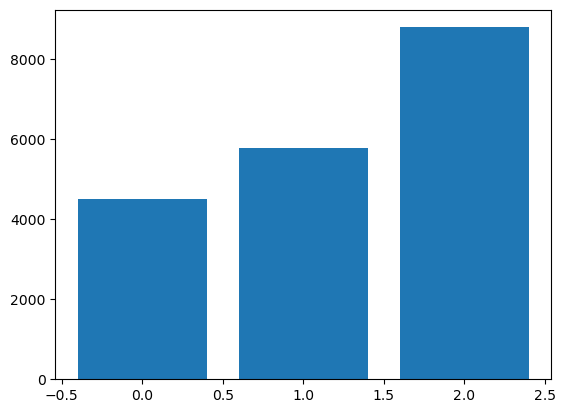

In [10]:
plt.bar(np.unique(y_train), np.unique(y_train, return_counts=True)[1])

<BarContainer object of 3 artists>

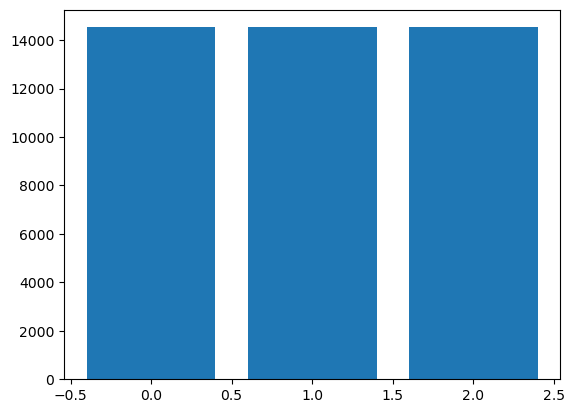

In [11]:
from imblearn.over_sampling import SMOTE

ros = SMOTE()
  
# Fit predictor (x variable)
# and target (y variable) using fit_resample()
X, y = ros.fit_resample(X.copy(), y.copy())
plt.bar(np.unique(y), np.unique(y, return_counts=True)[1])

In [12]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

5

## Modeling

Now that I have my data all set, it is time to begin developing my models. I first needed to create a wide and deep model with several layers deep and the crossed values being embedded to be my width. I created a brief function to display my results, and then proceeded. 

### Wide and Deep Networks

In [13]:
#Graph accuracies and loss
def plot_model(a, a_val, l, l_val) : 
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(a)
    
    plt.ylabel('accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(a_val)
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(l)
    plt.ylabel('Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(l_val)
    plt.xlabel('epochs')

#### Model 1

I create our first wide and deep network. I created the frame from Eric Larson's notebook. In this network I utilized 5 seperate layers to create ample depth. I then utilized the adagrad optimization method. <br/>

In [14]:
accuracies = []
accuracies_val = []
losses = []
losses_val = []

for i in range(50):
    inner1 = []
    for j in range(5):
        inner1.append(0)
    losses_val.append(inner1)
    inner2 = []
    for j in range(5):
        inner2.append(0)
    losses.append(inner2)
    inner3 = []
    for j in range(5):
        inner3.append(0)
    accuracies_val.append(inner3)
    inner4 = []
    for j in range(5):
        inner4.append(0)
    accuracies.append(inner4)

count = 0
for train_index, test_index in skf.split(X, y) : 
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # get crossed columns
    X_train_crossed = x_train_fold[cross_col_df_names].to_numpy()
    X_test_crossed = x_test_fold[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = x_train_fold[categorical_headers_ints].to_numpy() 
    X_test_cat = x_test_fold[categorical_headers_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  x_train_fold[numeric_headers].to_numpy()
    X_test_num = x_test_fold[numeric_headers].to_numpy()


    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED df INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N = len(encoders[col].classes_)
        N_reduced = int(np.sqrt(N))
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []
    # CATEGORICAL df INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N_reduced = int(np.sqrt(N))
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC df INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

    model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

    model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

    # lets also add the history variable to see how we are doingg
    # and lets add a validation set to keep track of our progress
    history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train_fold, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test_fold))

    for index in range(len(history.history['accuracy'])) : 
        accuracies[index][count] = history.history['accuracy'][index]
        accuracies_val[index][count] = history.history['val_accuracy'][index]
        losses[index][count] = history.history['loss'][index]
        losses_val[index][count] = history.history['val_loss'][index]
    count += 1

2022-11-15 20:41:52.508210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 20:41:52.508433: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Once the model is completed, I graphed the averages of each our training and testing values for our model over all of my iterations. From my results below, I can see that while the accuracy isn't ideal, the model translates particularly well from training to testing data. 

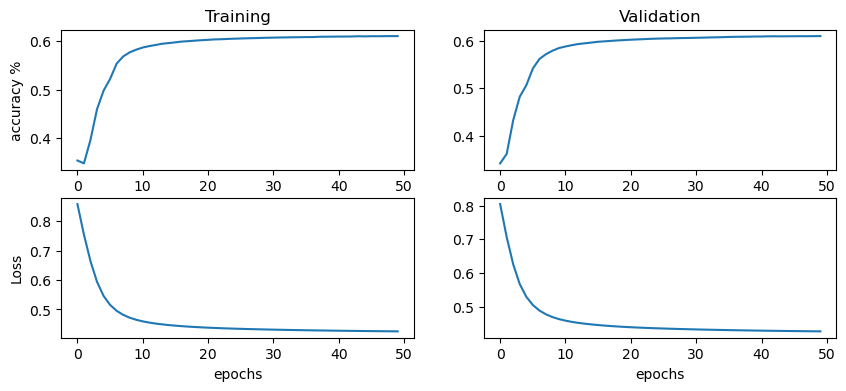

In [16]:
for row in range(len(accuracies)) :
    accuracies[row] = np.mean(accuracies[row])
    losses[row] = np.mean(losses[row])
    accuracies_val[row] = np.mean(accuracies_val[row])
    losses_val[row] = np.mean(losses_val[row])
    
plot_model(accuracies, accuracies_val, losses, losses_val)

#### Model 2

Then, I create our second wide and deep network. In this network I utilized 5 seperate layers to create ample depth. I then utilized the Nadam optimization method. <br/>

In [17]:
accuracies = []
accuracies_val = []
losses = []
losses_val = []

for i in range(50):
    inner1 = []
    for j in range(5):
        inner1.append(0)
    losses_val.append(inner1)
    inner2 = []
    for j in range(5):
        inner2.append(0)
    losses.append(inner2)
    inner3 = []
    for j in range(5):
        inner3.append(0)
    accuracies_val.append(inner3)
    inner4 = []
    for j in range(5):
        inner4.append(0)
    accuracies.append(inner4)

count = 0
for train_index, test_index in skf.split(X, y) : 
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # get crossed columns
    X_train_crossed = x_train_fold[cross_col_df_names].to_numpy()
    X_test_crossed = x_test_fold[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = x_train_fold[categorical_headers_ints].to_numpy() 
    X_test_cat = x_test_fold[categorical_headers_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  x_train_fold[numeric_headers].to_numpy()
    X_test_num = x_test_fold[numeric_headers].to_numpy()


    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED df INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N = len(encoders[col].classes_)
        N_reduced = int(np.sqrt(N))
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []
    # CATEGORICAL df INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N_reduced = int(np.sqrt(N))
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC df INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

    model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

    model.compile(optimizer='Nadam',
              loss='mean_squared_error',
              metrics=['accuracy'])

    # lets also add the history variable to see how we are doingg
    # and lets add a validation set to keep track of our progress
    history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train_fold, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test_fold))

    for index in range(len(history.history['accuracy'])) : 
        accuracies[index][count] = history.history['accuracy'][index]
        accuracies_val[index][count] = history.history['val_accuracy'][index]
        losses[index][count] = history.history['loss'][index]
        losses_val[index][count] = history.history['val_loss'][index]
    count += 1

From the below accuracy, I can tell that our accuracy isn't particularly good, and that when it comes to applying our model to the testing data, it tends to not run very fluently. 

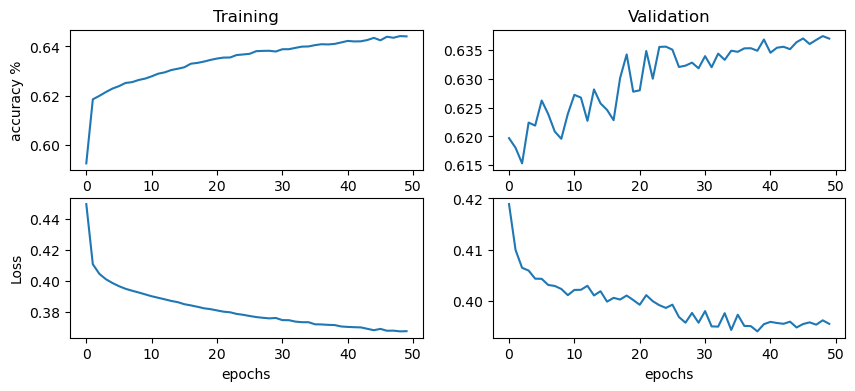

In [18]:
for row in range(len(accuracies)) :
    accuracies[row] = np.mean(accuracies[row])
    losses[row] = np.mean(losses[row])
    accuracies_val[row] = np.mean(accuracies_val[row])
    losses_val[row] = np.mean(losses_val[row])
    
plot_model(accuracies, accuracies_val, losses, losses_val)

#### Model 3

Then, I create our third wide and deep network. In this network I utilized 5 seperate layers to create ample depth. I then utilized the SGD optimization method. <br/>

In [28]:
accuracies = []
accuracies_val = []
losses = []
losses_val = []

for i in range(50):
    inner1 = []
    for j in range(5):
        inner1.append(0)
    losses_val.append(inner1)
    inner2 = []
    for j in range(5):
        inner2.append(0)
    losses.append(inner2)
    inner3 = []
    for j in range(5):
        inner3.append(0)
    accuracies_val.append(inner3)
    inner4 = []
    for j in range(5):
        inner4.append(0)
    accuracies.append(inner4)

count = 0
for train_index, test_index in skf.split(X, y) : 
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # get crossed columns
    X_train_crossed = x_train_fold[cross_col_df_names].to_numpy()
    X_test_crossed = x_test_fold[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = x_train_fold[categorical_headers_ints].to_numpy() 
    X_test_cat = x_test_fold[categorical_headers_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  x_train_fold[numeric_headers].to_numpy()
    X_test_num = x_test_fold[numeric_headers].to_numpy()


    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED df INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N = len(encoders[col].classes_)
        N_reduced = int(np.sqrt(N))
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []
    # CATEGORICAL df INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N_reduced = int(np.sqrt(N))
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC df INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

    model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

    model.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'])

    # lets also add the history variable to see how we are doingg
    # and lets add a validation set to keep track of our progress
    history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train_fold, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test_fold))

    for index in range(len(history.history['accuracy'])) : 
        accuracies[index][count] = history.history['accuracy'][index]
        accuracies_val[index][count] = history.history['val_accuracy'][index]
        losses[index][count] = history.history['loss'][index]
        losses_val[index][count] = history.history['val_loss'][index]
    count += 1

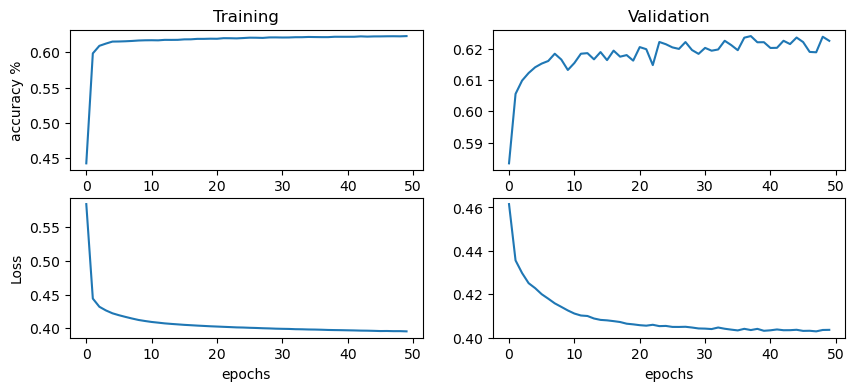

In [30]:
for row in range(len(accuracies)) :
    accuracies[row] = np.mean(accuracies[row])
    losses[row] = np.mean(losses[row])
    accuracies_val[row] = np.mean(accuracies_val[row])
    losses_val[row] = np.mean(losses_val[row])
    
plot_model(accuracies, accuracies_val, losses, losses_val)

#### Performance Analysis

From my above analysis, I can tell that overall the average accuracy remains the same regardless of the optimization method applied. While said accuracy isn't ideal, it could definately be improved with a bit more time to tweak it. However, what optimization does have a big effect on, is how accuracy translated from my testing data to my training data. The ideal algorithm for that is adagrad, which achieves essentially the same results but remains consistent past our training data set. 

### Layer Performance Analysis 

Now that we know the affect of different types of optimization methods. I now proceeded to check how the layers affected the overall results. 

#### 1 Layer

I first began by adding my previous structure, but with no added depth and having the only layer being the depth. 

In [31]:
accuracies = []
accuracies_val = []
losses = []
losses_val = []

for i in range(50):
    inner1 = []
    for j in range(5):
        inner1.append(0)
    losses_val.append(inner1)
    inner2 = []
    for j in range(5):
        inner2.append(0)
    losses.append(inner2)
    inner3 = []
    for j in range(5):
        inner3.append(0)
    accuracies_val.append(inner3)
    inner4 = []
    for j in range(5):
        inner4.append(0)
    accuracies.append(inner4)

count = 0
for train_index, test_index in skf.split(X, y) : 
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # get crossed columns
    X_train_crossed = x_train_fold[cross_col_df_names].to_numpy()
    X_test_crossed = x_test_fold[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = x_train_fold[categorical_headers_ints].to_numpy() 
    X_test_cat = x_test_fold[categorical_headers_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  x_train_fold[numeric_headers].to_numpy()
    X_test_num = x_test_fold[numeric_headers].to_numpy()


    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED df INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N = len(encoders[col].classes_)
        N_reduced = int(np.sqrt(N))
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []
    # CATEGORICAL df INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N_reduced = int(np.sqrt(N))
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC df INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

    model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

    model.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'])

    # lets also add the history variable to see how we are doingg
    # and lets add a validation set to keep track of our progress
    history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train_fold, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test_fold))

    for index in range(len(history.history['accuracy'])) : 
        accuracies[index][count] = history.history['accuracy'][index]
        accuracies_val[index][count] = history.history['val_accuracy'][index]
        losses[index][count] = history.history['loss'][index]
        losses_val[index][count] = history.history['val_loss'][index]
    count += 1

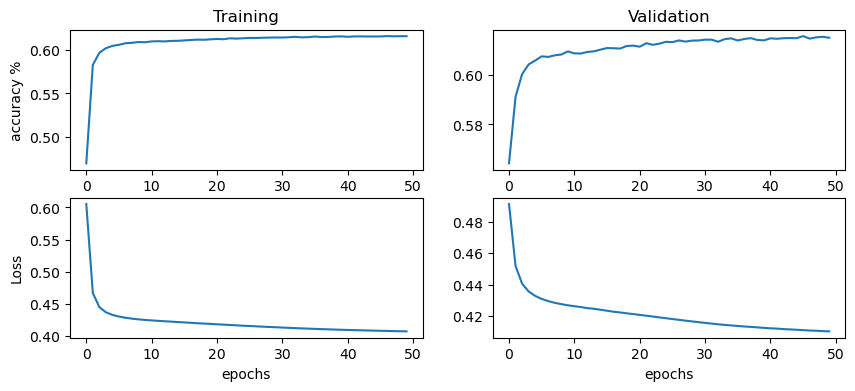

In [32]:
for row in range(len(accuracies)) :
    accuracies[row] = np.mean(accuracies[row])
    losses[row] = np.mean(losses[row])
    accuracies_val[row] = np.mean(accuracies_val[row])
    losses_val[row] = np.mean(losses_val[row])
    
plot_model(accuracies, accuracies_val, losses, losses_val)

#### 2 Layer

Then I repeated the process with one layer of depth by adding a dense layer to all of my inputs using the relu activation function.

In [33]:
accuracies = []
accuracies_val = []
losses = []
losses_val = []

for i in range(50):
    inner1 = []
    for j in range(5):
        inner1.append(0)
    losses_val.append(inner1)
    inner2 = []
    for j in range(5):
        inner2.append(0)
    losses.append(inner2)
    inner3 = []
    for j in range(5):
        inner3.append(0)
    accuracies_val.append(inner3)
    inner4 = []
    for j in range(5):
        inner4.append(0)
    accuracies.append(inner4)

count = 0
for train_index, test_index in skf.split(X, y) : 
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # get crossed columns
    X_train_crossed = x_train_fold[cross_col_df_names].to_numpy()
    X_test_crossed = x_test_fold[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = x_train_fold[categorical_headers_ints].to_numpy() 
    X_test_cat = x_test_fold[categorical_headers_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  x_train_fold[numeric_headers].to_numpy()
    X_test_num = x_test_fold[numeric_headers].to_numpy()


    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED df INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N = len(encoders[col].classes_)
        N_reduced = int(np.sqrt(N))
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []
    # CATEGORICAL df INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N_reduced = int(np.sqrt(N))
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC df INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

    model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

    model.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'])

    # lets also add the history variable to see how we are doingg
    # and lets add a validation set to keep track of our progress
    history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train_fold, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test_fold))

    for index in range(len(history.history['accuracy'])) : 
        accuracies[index][count] = history.history['accuracy'][index]
        accuracies_val[index][count] = history.history['val_accuracy'][index]
        losses[index][count] = history.history['loss'][index]
        losses_val[index][count] = history.history['val_loss'][index]
    count += 1

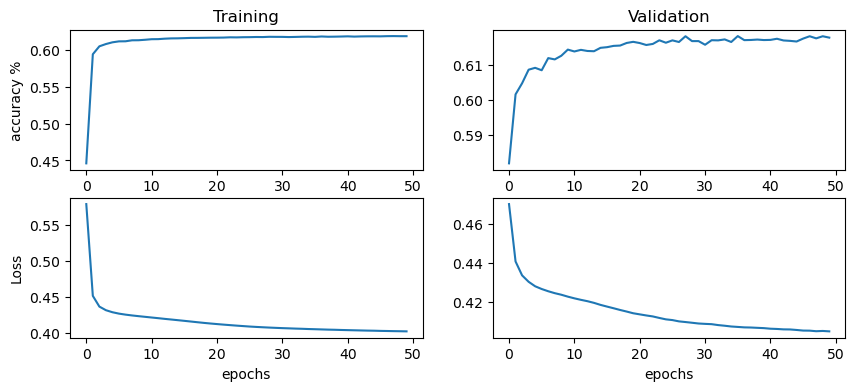

In [34]:
for row in range(len(accuracies)) :
    accuracies[row] = np.mean(accuracies[row])
    losses[row] = np.mean(losses[row])
    accuracies_val[row] = np.mean(accuracies_val[row])
    losses_val[row] = np.mean(losses_val[row])
    
plot_model(accuracies, accuracies_val, losses, losses_val)

#### 3 Layer

Finally, I repeated the process with three layers of added depth utilizing relu and tanh activiation functions.

In [35]:
accuracies = []
accuracies_val = []
losses = []
losses_val = []

for i in range(50):
    inner1 = []
    for j in range(5):
        inner1.append(0)
    losses_val.append(inner1)
    inner2 = []
    for j in range(5):
        inner2.append(0)
    losses.append(inner2)
    inner3 = []
    for j in range(5):
        inner3.append(0)
    accuracies_val.append(inner3)
    inner4 = []
    for j in range(5):
        inner4.append(0)
    accuracies.append(inner4)

count = 0
for train_index, test_index in skf.split(X, y) : 
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # get crossed columns
    X_train_crossed = x_train_fold[cross_col_df_names].to_numpy()
    X_test_crossed = x_test_fold[cross_col_df_names].to_numpy()

    # save categorical features
    X_train_cat = x_train_fold[categorical_headers_ints].to_numpy() 
    X_test_cat = x_test_fold[categorical_headers_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  x_train_fold[numeric_headers].to_numpy()
    X_test_num = x_test_fold[numeric_headers].to_numpy()


    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED df INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N = len(encoders[col].classes_)
        N_reduced = int(np.sqrt(N))
    
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        crossed_outputs.append(x)
    

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []
    # CATEGORICAL df INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N_reduced = int(np.sqrt(N))
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC df INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='tanh', name='deep2')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

    model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

    model.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'])

    # lets also add the history variable to see how we are doingg
    # and lets add a validation set to keep track of our progress
    history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train_fold, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test_fold))

    for index in range(len(history.history['accuracy'])) : 
        accuracies[index][count] = history.history['accuracy'][index]
        accuracies_val[index][count] = history.history['val_accuracy'][index]
        losses[index][count] = history.history['loss'][index]
        losses_val[index][count] = history.history['val_loss'][index]
    count += 1

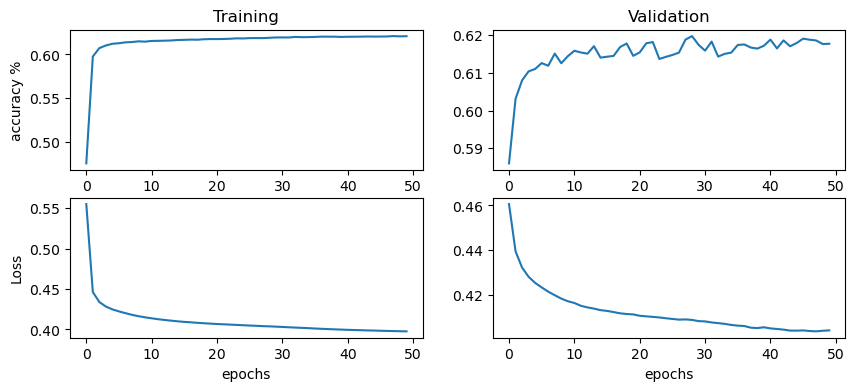

In [36]:
for row in range(len(accuracies)) :
    accuracies[row] = np.mean(accuracies[row])
    losses[row] = np.mean(losses[row])
    accuracies_val[row] = np.mean(accuracies_val[row])
    losses_val[row] = np.mean(losses_val[row])
    
plot_model(accuracies, accuracies_val, losses, losses_val)

Once we have run all of our measures, we can now evaluate what the affect of each layer is. <br/>

### Effect of Deep and Wide

Now that we have a functioning deep and wide network, we can compare it's performance to the Multi-Layer Perceptron we were working with. In order to compare we must run both our best performing model and a standard MLP. <br/>
I created a Multi-Layer Perceptron by still using keras without the added width. I ran it with only two layers of depth, and then created the results.  <br/>
Then I compared with my results above, where our best performing model was ...

In [37]:
accuracies = []
accuracies_val = []
losses = []
losses_val = []

for i in range(50):
    inner1 = []
    for j in range(5):
        inner1.append(0)
    losses_val.append(inner1)
    inner2 = []
    for j in range(5):
        inner2.append(0)
    losses.append(inner2)
    inner3 = []
    for j in range(5):
        inner3.append(0)
    accuracies_val.append(inner3)
    inner4 = []
    for j in range(5):
        inner4.append(0)
    accuracies.append(inner4)

count = 0
for train_index, test_index in skf.split(X, y) : 
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # save categorical features
    X_train_cat = x_train_fold[categorical_headers_ints].to_numpy() 
    X_test_cat = x_test_fold[categorical_headers_ints].to_numpy() 

    # and save off the numeric features
    X_train_num =  x_train_fold[numeric_headers].to_numpy()
    X_test_num = x_test_fold[numeric_headers].to_numpy()


    # reset this input branch
    all_deep_branch_outputs = []
    # CATEGORICAL df INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):
    
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1
        N_reduced = int(np.sqrt(N))
    
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
    
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
    
    # NUMERIC df INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    
    # merge the deep and wide branch
    final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(deep_branch)

    model = Model(inputs=[input_cat,input_num], 
              outputs=final_branch)

    model.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'])

    # lets also add the history variable to see how we are doingg
    # and lets add a validation set to keep track of our progress
    history = model.fit([X_train_cat,X_train_num],
                    y_train_fold, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_cat,X_test_num],y_test_fold))

    for index in range(len(history.history['accuracy'])) : 
        accuracies[index][count] = history.history['accuracy'][index]
        accuracies_val[index][count] = history.history['val_accuracy'][index]
        losses[index][count] = history.history['loss'][index]
        losses_val[index][count] = history.history['val_loss'][index]
    count += 1

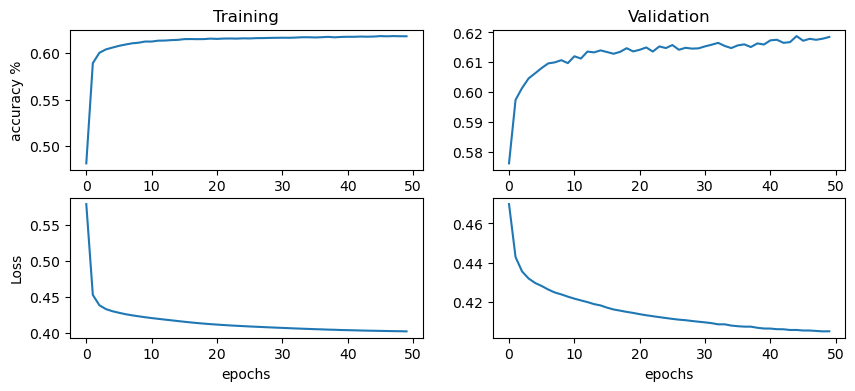

In [38]:
for row in range(len(accuracies)) :
    accuracies[row] = np.mean(accuracies[row])
    losses[row] = np.mean(losses[row])
    accuracies_val[row] = np.mean(accuracies_val[row])
    losses_val[row] = np.mean(losses_val[row])
    
plot_model(accuracies, accuracies_val, losses, losses_val)